In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

np.random.seed(34)
sns.set()

### Данные

In [2]:
num_dots = 20  # кол-во точек
deg_from = -130
deg_to = 130
degree = 15  # степень многочлена
rand_coeff = 0.3  # уровень шума

# Синусоида.
real_x = np.linspace(deg_from, deg_to, 10000) * np.pi / 180
real_y = np.sin(real_x)

# Точки вокруг синусоиды с некоторым шумом.
x = np.linspace(deg_from, deg_to, num_dots) * np.pi / 180
y = np.sin(x) + np.random.randn(num_dots) * rand_coeff

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.66, shuffle=True)

# Будем аппроксимировать многочленом.
x_train_deg = np.array([x_train ** deg for deg in range(1, degree + 1)]).transpose()
x_test_deg = np.array([x_test ** deg for deg in range(1, degree + 1)]).transpose()

x_train_deg.shape, x_test_deg.shape

((13, 15), (7, 15))

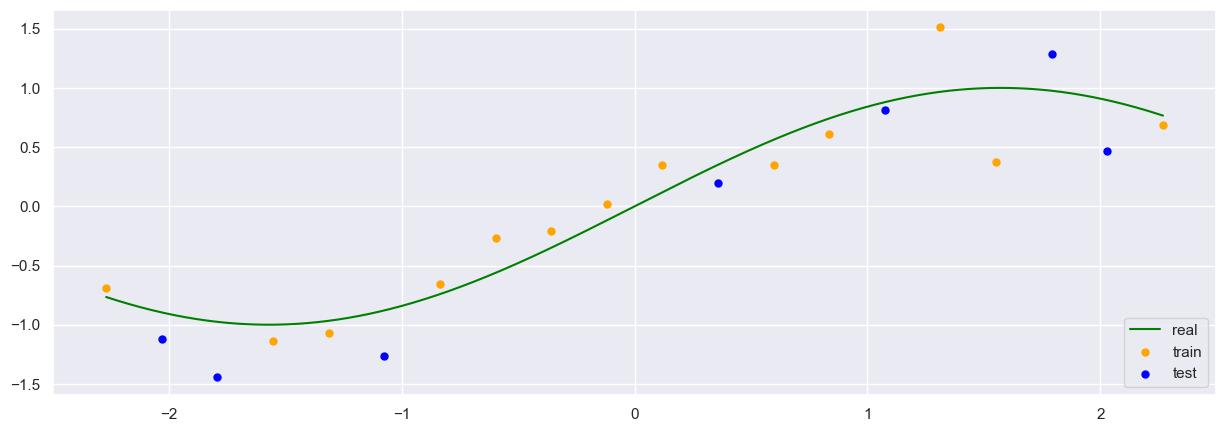

In [3]:
plt.figure(figsize=(15, 5))
plt.plot(real_x, real_y, c="green", label="real")
plt.scatter(x_train, y_train, linewidths=0.01, c="orange", label="train")
plt.scatter(x_test, y_test, linewidths=0.01, c="blue", label="test")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Класс линейной регрессии с $L2$-регуляризацией. Минимизируется следующая функция:

$$
\frac{1}{m} \sum_{i=1}^m (w^T x_i + b - y_i)^2 + \lambda \cdot \|w\|_2^2
$$

In [4]:
class RegularizedLinearRegression:
    """Класс линейной регрессии с регуляризацией."""

    def __init__(self, learning_rate=0.005, l2_reg=0, epochs=1, report_interval=1):
        self.learning_rate = learning_rate  # шаг обучения
        self.l2_reg = l2_reg  # коэффициент регуляризации
        self.epochs = epochs  # кол-во шагов градиентного спуска
        self.report_interval = report_interval  # через какой интервал считать характеристики

        self.num_obj = None  # кол-во объектов в обучающем наборе
        self.num_feat = None  # кол-во признаков
        self.weights = None  # веса
        self.bias = None  # свободный член

    def fit(self, X, y, eval_set=None):
        """Метод обучения модели."""

        # Количество объектов и признаков.
        self.num_obj, self.num_feat = X.shape
        # Инициализация весов (вектор 1 x num_feat) и свободного члена по закону нормального распределения.
        self.weights = np.random.randn(self.num_feat, 1) * 0.001
        self.bias = np.random.randn() * 0.001

        # Эпохи - кол-во проходов по всему набору данных или кол-во шагов по антиградиенту.
        for epoch in range(self.epochs):
            # Расчёт градиента.
            grad_w = (2 / self.num_obj) * X.T @ (X @ self.weights + self.bias - y.reshape(-1, 1))
            grad_b = float(np.mean(2 * (X @ self.weights + self.bias - y.reshape(-1, 1))))
            grad_reg = 2 * self.l2_reg * self.weights

            # Корректировка весов и свободного члена. Шаг в сторону антиградиента.
            self.weights = self.weights - self.learning_rate * (grad_w + grad_reg)
            self.bias = self.bias - self.learning_rate * grad_b

            # Вывод промежуточной информации.
            if epoch % self.report_interval == 0 and eval_set is not None:
                train_loss = self.count_loss(X, y)
                self.print_loss(*train_loss, "Train")
                test_loss = self.count_loss(eval_set[0], eval_set[1])
                self.print_loss(*test_loss, "Test")
                print("-" * 42)

    def count_loss(self, X, y):
        """Метод расчёта MSE и регуляризации."""
        mse = np.square(X @ self.weights + self.bias - y.reshape(-1, 1)).mean()
        reg = self.l2_reg * float(self.weights.T @ self.weights) / X.shape[0]
        return mse, reg

    @staticmethod
    def print_loss(mse, reg, mode):
        """Метод вывода ошибки."""
        print(f"{mode} MSE: {round(mse, 3)}")
        print(f"{mode} loss: {round(mse + reg, 3)}")

**Нормализация**

In [5]:
means = x_train_deg.mean(axis=0).reshape(1, -1)
stds = x_train_deg.std(axis=0).reshape(1, -1)

x_train_deg = (x_train_deg - means) / stds
x_test_deg = (x_test_deg - means) / stds

**Обучение модели**

In [6]:
model = RegularizedLinearRegression(l2_reg=0, learning_rate=0.05, epochs=1000, report_interval=200)
model.fit(x_train_deg, y_train, eval_set=(x_test_deg, y_test))

Train MSE: 0.387
Train loss: 0.387
Test MSE: 0.765
Test loss: 0.765
------------------------------------------
Train MSE: 0.063
Train loss: 0.063
Test MSE: 0.099
Test loss: 0.099
------------------------------------------
Train MSE: 0.059
Train loss: 0.059
Test MSE: 0.091
Test loss: 0.091
------------------------------------------
Train MSE: 0.056
Train loss: 0.056
Test MSE: 0.097
Test loss: 0.097
------------------------------------------
Train MSE: 0.054
Train loss: 0.054
Test MSE: 0.11
Test loss: 0.11
------------------------------------------


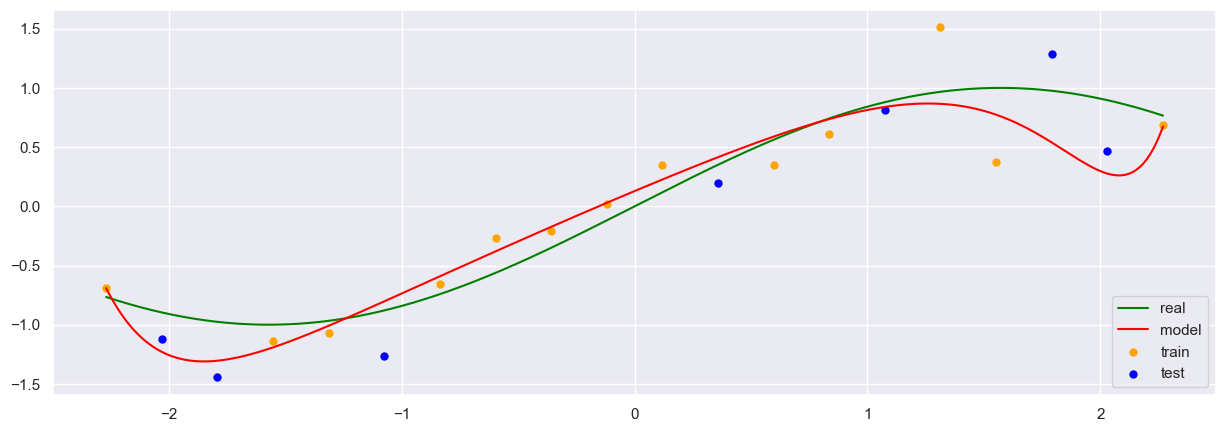

In [7]:
model_x = np.array([real_x ** deg for deg in range(1, degree + 1)]).transpose()
model_x = (model_x - means) / stds
model_y = model_x @ model.weights + model.bias

plt.figure(figsize=(15, 5))
plt.plot(real_x, real_y, c="green", label="real")
plt.plot(real_x, model_y, c="red", label="model")
plt.scatter(x_train, y_train, linewidths=0.01, c="orange", label="train")
plt.scatter(x_test, y_test, linewidths=0.01, c="blue", label="test")
plt.legend(loc="lower right")
plt.show()

In [8]:
train_loss = model.count_loss(x_train_deg, y_train)
model.print_loss(*train_loss, "Train")

test_loss = model.count_loss(x_test_deg, y_test)
model.print_loss(*test_loss, "Test")

Train MSE: 0.053
Train loss: 0.053
Test MSE: 0.127
Test loss: 0.127


In [9]:
round(np.linalg.norm(model.weights), 2)

1.23

#### Добавим регуляризацию

In [10]:
model = RegularizedLinearRegression(l2_reg=0.05, learning_rate=0.05, epochs=1000, report_interval=200)
model.fit(x_train_deg, y_train, eval_set=(x_test_deg, y_test))

Train MSE: 0.387
Train loss: 0.387
Test MSE: 0.766
Test loss: 0.766
------------------------------------------
Train MSE: 0.069
Train loss: 0.071
Test MSE: 0.109
Test loss: 0.114
------------------------------------------
Train MSE: 0.068
Train loss: 0.07
Test MSE: 0.106
Test loss: 0.11
------------------------------------------
Train MSE: 0.067
Train loss: 0.07
Test MSE: 0.105
Test loss: 0.11
------------------------------------------
Train MSE: 0.067
Train loss: 0.07
Test MSE: 0.105
Test loss: 0.11
------------------------------------------


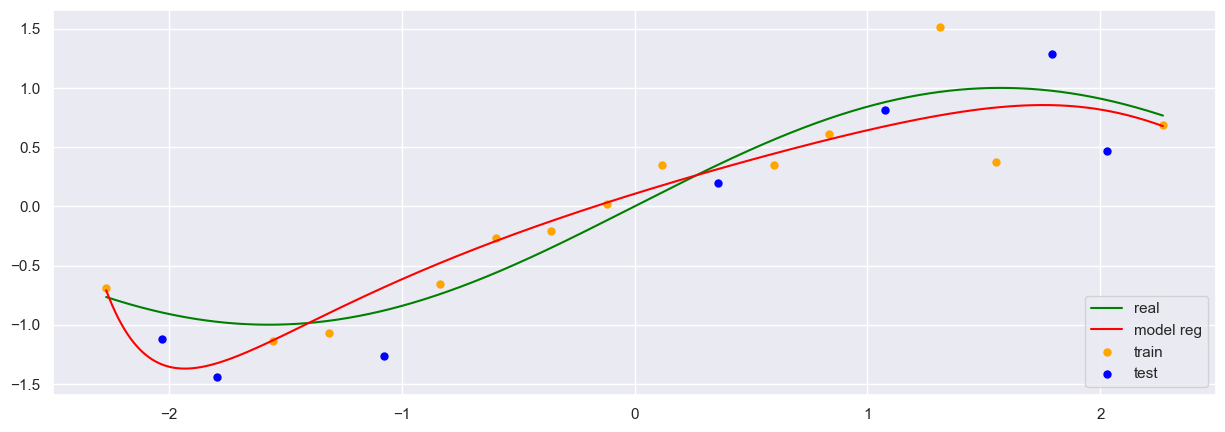

In [11]:
model_x = np.array([real_x ** deg for deg in range(1, degree + 1)]).transpose()
model_x = (model_x - means) / stds
model_y = model_x @ model.weights + model.bias

plt.figure(figsize=(15, 5))
plt.plot(real_x, real_y, c="green", label="real")
plt.plot(real_x, model_y, c="red", label="model reg")
plt.scatter(x_train, y_train, linewidths=0.01, c="orange", label="train")
plt.scatter(x_test, y_test, linewidths=0.01, c="blue", label="test")
plt.legend(loc="lower right")
plt.show()

In [12]:
train_loss = model.count_loss(x_train_deg, y_train)
model.print_loss(*train_loss, "Train")

test_loss = model.count_loss(x_test_deg, y_test)
model.print_loss(*test_loss, "Test")

Train MSE: 0.067
Train loss: 0.07
Test MSE: 0.105
Test loss: 0.11


In [13]:
round(np.linalg.norm(model.weights), 2)

0.82

**Изменение ошибок в зависимости от коэффициента регуляризации**

In [14]:
%%capture

reg_coefs = np.logspace(-3, 1, 20)
test_losses = []
train_losses = []
norms = []

for reg_coef in reg_coefs:
    model = RegularizedLinearRegression(l2_reg=reg_coef, learning_rate=0.05, epochs=2000)
    model.fit(x_train_deg, y_train)
    test_losses.append(model.count_loss(x_test_deg, y_test)[0])
    train_losses.append(model.count_loss(x_train_deg, y_train)[0])
    norms.append(np.linalg.norm(model.weights))

Чем меньше регуляризация, тем сложнее модель.

In [15]:
norms = norms[::-1]
train_losses = train_losses[::-1]
test_losses = test_losses[::-1]
reg_coefs = reg_coefs.round(5).astype(str)
reg_coefs = reg_coefs[::-1]

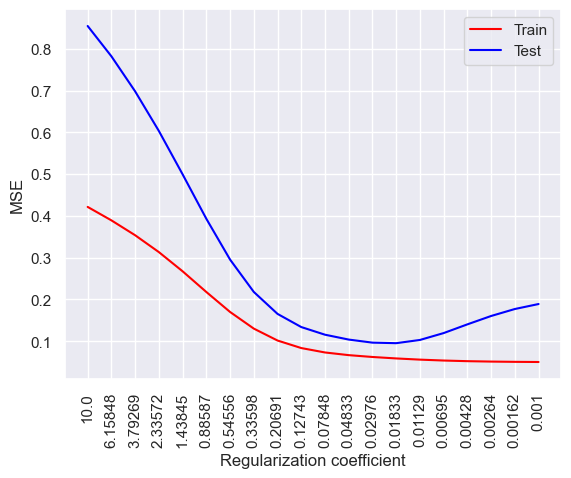

In [16]:
plt.plot(reg_coefs, train_losses, label="Train", c="red")
plt.plot(reg_coefs, test_losses, label="Test", c="blue")
plt.xticks(rotation = 90)
plt.ylabel("MSE")
plt.xlabel("Regularization coefficient")
plt.legend()
plt.show()

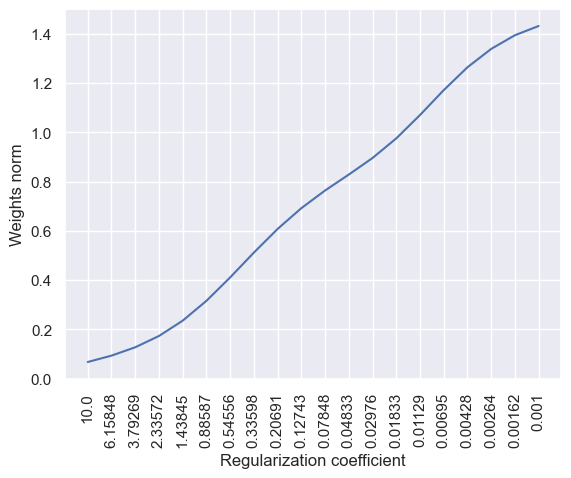

In [17]:
plt.plot(reg_coefs, norms)
plt.ylabel("Weights norm")
plt.xticks(rotation = 90)
plt.xlabel("Regularization coefficient")
plt.show()